In [14]:
from multiprocessing import Pool
import multiprocessing as mp
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from astropy.wcs import WCS
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import spearmanr

from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm
import datetime

import emcee
import corner

import h5py
import multiprocessing as mp

In [15]:
import globalvars
dust_data = globalvars.DustData()

In [16]:
map_fname = '/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/edenhofer_out.h5'

with h5py.File(map_fname, 'r') as f:
    edenhofer = np.array(f['data'])
    dust_data.intake_map(edenhofer)

/tmp/ipykernel_3945617/2315330892.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  edenhofer = np.array(f['data'])


In [17]:
from specfns import get_wavs, resample_interp, dopplershift, lambda0, sigma0
from filehandling import get_ca_res, get_madgics_res, get_medres
from spacefns_v2 import select_stars, find_nearest, find_radius, differentialAmplitude
from MCMCfns import logprob_2
from sightline import Sightline
import time

In [18]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)

# added 02.01
data_criteria = (((CA_meta['SNR'] > 80) & (CA_meta['TEFF'] > 5000)) | (CA_meta['SNR'] > 150)) & (CA_meta['ASPCAP_CHI2_1'] > 1) & (CA_meta['ASPCAP_CHI2_1'] < 5)
print(np.sum(data_criteria))
CA_meta= CA_meta[data_criteria]

1010


In [19]:
wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]

In [20]:
ds = 2.5 # x downsampled
rad = 0.23
sample_dim_l = np.linspace(159, 167, int(8 / (ds * rad)))
sample_dim_b = np.linspace(-12.5 , -4.5, int(8 / (ds * rad)))
sample_grid_l, sample_grid_b = np.meshgrid(sample_dim_l, sample_dim_b)
grid_map_inds = np.array([find_nearest(sample_grid_l.flatten()[i], sample_grid_b.flatten()[i]) for i in range(len(sample_grid_l.flatten()))]).T
grid_map = np.nansum(np.copy(edenhofer[grid_map_inds[1], grid_map_inds[0], :]).reshape(*sample_grid_l.shape, -1), axis = 2)
grid_Nstar = np.array([np.nansum((np.abs((sample_grid_l.flatten()[i] - CA_meta['GLON'])) <= rad) & 
            (np.abs((sample_grid_b.flatten()[i] - CA_meta['GLAT'])) <= rad)) for i in range(len(sample_grid_l.flatten()))]).reshape(*sample_grid_l.shape)

filament_l = (159, 169)
filament_b = (-10, -6)

N_min = 5
radius_min = np.zeros(sample_grid_l.shape)
mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
for i in mgrid[0].flatten():
    for j in mgrid[1].flatten():
        radius_min[i, j] = find_radius(sample_grid_l[i, j], sample_grid_b[i, j], N_min, CA_meta)
        radius_min[i, j] = np.max([radius_min[i, j], 0.23])

radius_max = 0.4
print(np.nansum(radius_min < radius_max))


crit_filament = ((sample_grid_l > filament_l[0]) & (sample_grid_l < filament_l[1]) & 
                 (sample_grid_b > filament_b[0]) & (sample_grid_b < filament_b[1]) &
                 (grid_map > 2.2) & (radius_min < 0.5)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

crit_background =  (((sample_grid_l <= filament_l[0]) | (sample_grid_l >= filament_l[1]) |
                 (sample_grid_b <= filament_b[0]) | (sample_grid_b >= filament_b[1])) &
                 (grid_map <= 1.5) & (radius_min < radius_max)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

# crit_coverage = (np.sum() => 1 & )

N_filament = np.sum(crit_filament)
N_background = np.sum(crit_background)
print(np.sum(crit_filament))
print(np.sum(crit_background))
l_fil, b_fil, AV_fil = (sample_grid_l[crit_filament].flatten(), sample_grid_b[crit_filament].flatten(),
                        grid_map[crit_filament].flatten())
l_off, b_off, AV_off = (sample_grid_l[crit_background].flatten(), sample_grid_b[crit_background].flatten(),
                        grid_map[crit_background].flatten())

l_sample, b_sample, AV_sample = (np.concatenate([l_fil, l_off]), np.concatenate([b_fil, b_off]),
                                  np.concatenate([AV_fil, AV_off]))
radius_min_fil = radius_min[crit_filament].flatten()
radius_min_off = radius_min[crit_background].flatten()
radius_sample = np.concatenate([radius_min_fil, radius_min_off])

selected_inds = []
for i in range(len(l_sample)):
    l_center, b_center = l_sample[i], b_sample[i]
    rad_i = radius_sample[i]
    selection = select_stars(CA_meta, l_center, b_center, radius = rad_i)
    # print(len(selection))
    selected_inds.append(selection)

91
23
28


In [56]:
0.4 * 60

24.0

In [21]:
dibfn = lambda x, mu, sigma, a: 1-a * np.exp(-0.5 * (x - mu)**2 / sigma**2)
def sigma_clip_mask(y, x = wavs, k = 2.5):
    y_over_gauss = None

    try:
        gaussfit = curve_fit(dibfn, x[window], y[window].filled(np.nan), p0 = (15272, 1.2, 0.05), bounds = ([15269, 0.5, 0], [15275, 2, 0.15]), check_finite = False, nan_policy = 'omit')

    except:
        # gaussfit = ((15272, 1.2, 0.05),())
        print('fail')
        return None, None
    #     y_over_gauss = None
    #     gaussfit = ((15272, 1.2, 0.05),())
    #     # fit = dibfn(x, 15272.42, 1.2, 0.05)
    #     # y_over_gauss = y / fit
    #     print('POOR GAUSS FIT IN SIGMA CLIP')
    y_over_gauss = y / dibfn(x, *gaussfit[0])

    med = np.nanmedian(y_over_gauss[window])
    stdev = np.std(y_over_gauss[window], ddof = 1)
    mask = np.abs(y_over_gauss - med) > k * stdev
    mask = mask + np.roll(mask, -1) + np.roll(mask, -1)
    mask = mask.astype(bool)
    return mask, stdev

def sigmaClip(y, yerr,k=2.5):
    clip = True
    clip_iters = 0
    std = np.nanstd(y[window], ddof = 1)
    mask = np.zeros(y.shape).astype(bool)
    clip_success = True

    while clip:
        clip_mask, std_clipped = sigma_clip_mask(np.ma.array(y, mask = mask.copy()), k = k)
        if clip_mask is None:
            clip_success = False
            return mask, clip_success
        clip_mask = clip_mask.filled(False)

        if std - std_clipped  < 1e-4:
            clip = False


        else:
            clip_iters += 1
            std = std_clipped
            mask = mask + clip_mask

    return mask, clip_success

In [22]:
def generateClippedResidual(aspcap, medres, apstar, rv, k = 2.5):
    spectrum = aspcap[1].data
    model = aspcap[3].data
    err = aspcap[2].data
    bitmask = apstar[3].data[0, :]

    if medres[1].data is None:
        medres_model = np.ones(spectrum.shape)
        medres_err =np.zeros(spectrum.shape)
    else:
        medres_model = np.array(medres[1].data)
        medres_err = np.array(medres[3].data)



    mask_digits = [0, 1, 2, 9, 12, 13] # 0 BADPIX, 1 CRPIX, 2 SATPIX, 9 PERSIST_HIGH, 12 SIG_SKYLINE, 13 SIG_TELLURIC
    mask = np.zeros(bitmask.shape)
    for digit in mask_digits:
        mask = mask + np.bitwise_and(bitmask.astype(int), 2**digit) 

    mask = mask.astype(bool)
    res_corr = spectrum / model / medres_model
    # print('res corr shape', res_corr.shape)
    uncertainty_corr = np.sqrt(err**2 + medres_err**2)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)

    # mask_sigmaclip = np.zeros(len(wavs))


    maskSigClip, clip_success = sigmaClip(res_corr, uncertainty_corr, k = k)

    mask = mask + maskSigClip
    mask = mask.astype(bool)

    res_corr_ma = np.ma.array(res_corr, mask = mask)
    res_corr_filled = res_corr_ma.filled(np.nan)

    res_corr_resamp = resample_interp(res_corr_filled, rv)
    uncertainty_corr_resamp = resample_interp(uncertainty_corr, rv)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)


    res_corr_resamp = np.ma.array(res_corr_resamp, mask = manual_masks)
    res_corr_resamp = res_corr_resamp.filled(np.nan)


    return res_corr_resamp, uncertainty_corr_resamp#, clip_success

In [23]:
sightlines = []
for i in range(len(selected_inds)):
    sightlines.append(Sightline(CA_meta[selected_inds[i]], dustdata = dust_data)),#) alternative_data_processing = generateClippedResidual))

In [24]:
sightlines = sightlines[:3]

In [25]:
from  bayesianFramework import logprobability

def runMCMC(sl, steps = 500, nwalkers = 400, pool = None, filename = None):
    ndim = sl.ndim
    nstar = sl.nsig
    nparams = 2 * ndim + ndim * nstar
    
    if filename is not None:
        backend = emcee.backends.HDFBackend(filename)
        backend.reset(nwalkers, nparams)
    else:
        backend = None

    sampler = emcee.EnsembleSampler(nwalkers, nparams , logprobability, 
                                    kwargs={'sl': sl, 'k': 3}, pool = pool, backend = backend)
    
    init = 10 *  (np.random.random((nwalkers, nparams)) - 0.5)
    init[:, ndim:2*ndim] = np.abs(sl.voxel_dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:2*ndim].shape)-0.5))
    init[:, 2*ndim:] = 0.1* (np.random.random(size = init[:, 2*ndim:].shape) - 0.5)
    print('NDIM:', ndim, 'NSTAR:', nstar, 'INITSHAPE:', init.shape)
    
    sampler.run_mcmc(init,  steps, progress = True, skip_initial_state_check=True);
    
    return sampler, ndim, nparams, init

In [26]:
sl = sightlines[0]
if True:
    with mp.Pool(10) as pool:
        for i in range(len(sightlines)):
            sl_i = sightlines[i]
            sampler, _, __, init = runMCMC(sl_i, pool = pool, steps = 5000, nwalkers = 200, filename = 'RUNS_H5/sightline_5000iters_standard_{}.h5'.format(i),)
            sl_i.intake(sampler)

NDIM: 5 NSTAR: 5 INITSHAPE: (200, 35)


100%|██████████| 5000/5000 [09:38<00:00,  8.64it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (200, 35)


100%|██████████| 5000/5000 [09:35<00:00,  8.69it/s]


NDIM: 5 NSTAR: 5 INITSHAPE: (200, 35)


100%|██████████| 5000/5000 [09:03<00:00,  9.20it/s]


In [27]:
# from  bayesianFramework import logprobability

# logprobability(init, sightlines[0])

In [44]:
chains = []
probabilities = []
for i in range(len(sightlines)):
    reader = emcee.backends.HDFBackend('RUNS_H5/sightline_5000iters_standard_{}.h5'.format(i))
    chains.append(reader.get_chain())
    probabilities.append(reader.get_log_prob())

In [45]:
reader = emcee.backends.HDFBackend('RUNS_H5/sightline_5000_iters_standard_0.h5')
chain = reader.get_chain()
log_prob_vals = reader.get_log_prob()

AttributeError: You must run the sampler with 'store == True' before accessing the results

In [30]:
# logprobability(init[0, :], sl)

In [31]:
# def logprior_velocity(v):
#     if (np.any(v < -8.5)) or (np.any(v > 17.5)):
#         return -np.inf
#     return 0.0

# def logprior_davdd(av):
#     if np.any(av < 0):
#         return -np.inf
#     return 0.0

# def logprior_avscatter(av_offset):
#     a_std = 0.010189143589820518
#     val = -0.5 * np.nansum((av_offset)**2 / (a_std**2))
#     return val

In [32]:
# v = init[:, :sl.ndim]
# print(logprior_velocity(v))
# av = init[:, sl.ndim:2*sl.ndim]
# print(logprior_davdd(av))
# av_offset = init[:, 2*sl.ndim:]
# print(logprior_avscatter(av_offset))    

In [33]:

# sampler.run_mcmc(init, 5000, progress = True, skip_initial_state_check=True)

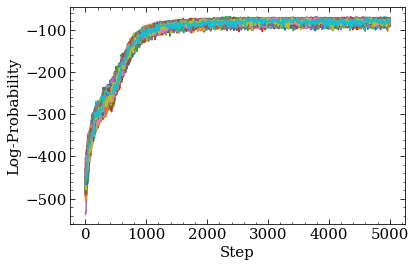

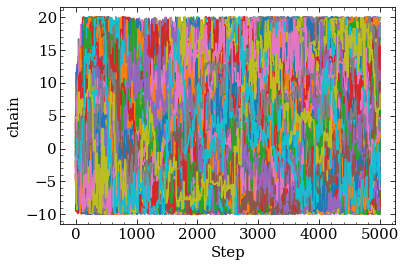

In [46]:
fig, ax = plt.subplots()
ax.plot(probabilities[0])
ax.set_xlabel('Step')
ax.set_ylabel('Log-Probability')
plt.show()

fig, ax = plt.subplots()
ax.plot(chains[0][:, :, 0])
ax.set_xlabel('Step')
ax.set_ylabel('chain')
plt.show()

In [47]:
np.unravel_index(np.argmax(probabilities[0]), probabilities[0].shape)

(4308, 166)

In [48]:
# fig, ax= plt.subplots()
# ax.plot(sampler.chain[:, :, 2].T, color = 'k', alpha = 0.1)

(20000, 5)


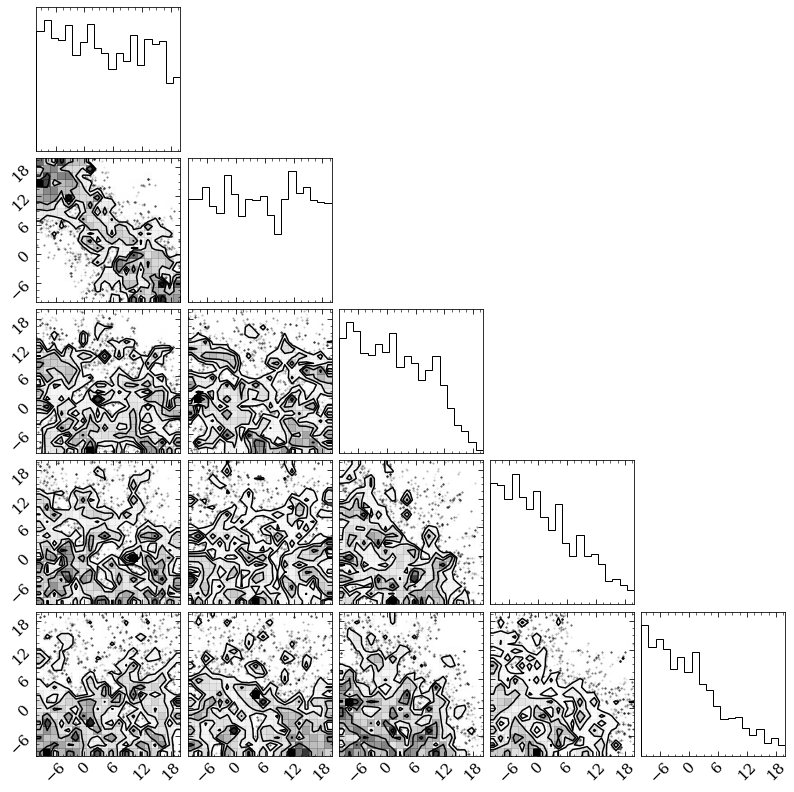

(20000, 5)


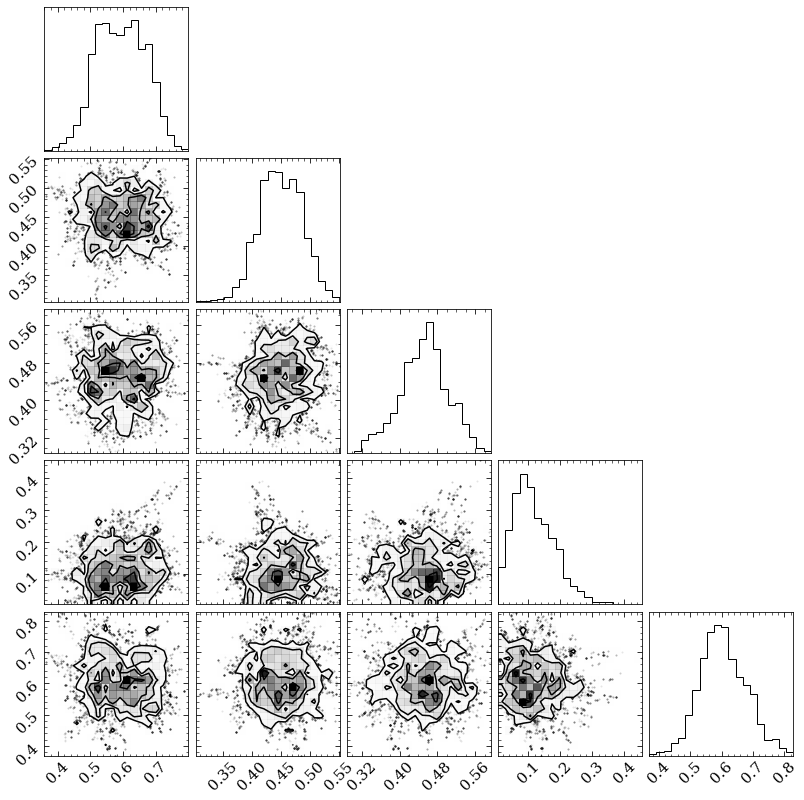

(100000, 5)


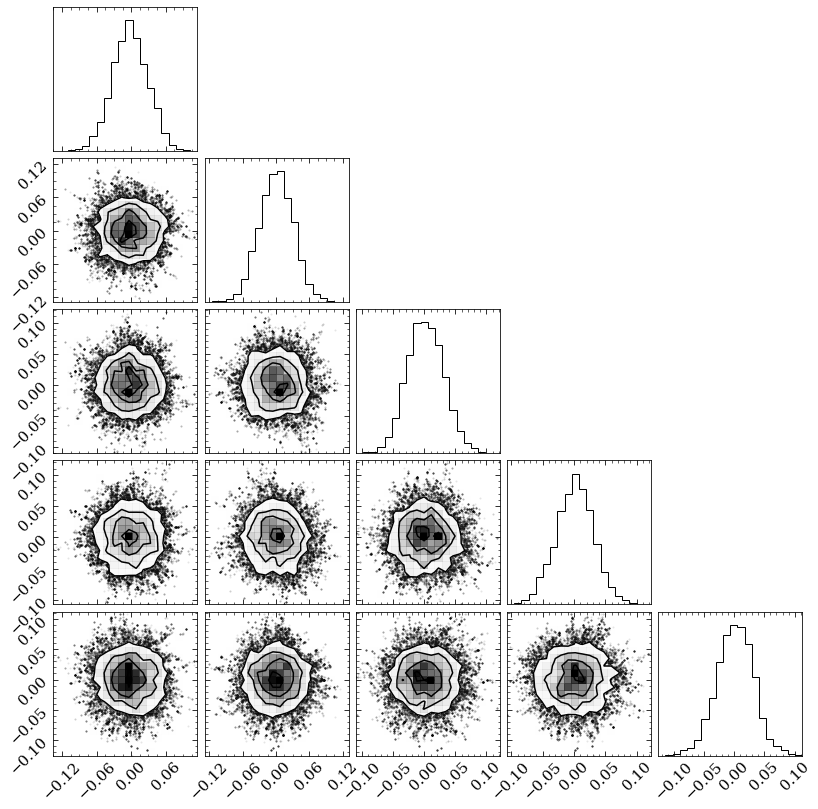

In [49]:
def make_corner_vonly(sampler, ndim, labels, chain = None, minval = -100):
    if chain is None:
        samples = sampler.chain[:, minval:, :ndim].reshape((-1, ndim))
    else:
        samples = chain[minval:, :, :ndim].reshape((-1, ndim))
    print(samples.shape)
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()
def make_corner_avonly(sampler, ndim, labels, chain = None,  minval = -100):
    if chain is None:
        samples = sampler.chain[:, minval:, ndim:2*ndim].reshape((-1, ndim))
    else:
        samples = chain[minval:, :, ndim:2*ndim].reshape((-1, ndim))
    print(samples.shape)
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()
def make_corner_av_offsetonly(sampler, ndim, nsig, labels, chain = None, minval = -100):

    # samples = sampler.chain[:, minval:, 2 * ndim:].reshape((-1, ndim * nsig))
    if chain is None:
        samples = sampler.chain[:, minval:, 2*ndim:].reshape((-1, ndim))
    else:
        samples = chain[minval:,:,  2*ndim:].reshape((-1, ndim))
    print(samples.shape)
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()
idx = 0
make_corner_vonly(None, sightlines[idx].ndim, None, chain = chains[idx])
make_corner_avonly(None, sightlines[idx].ndim, None, chain = chains[idx])
make_corner_av_offsetonly(None, sightlines[idx].ndim, sl.nsig, None, chain = chains[idx])

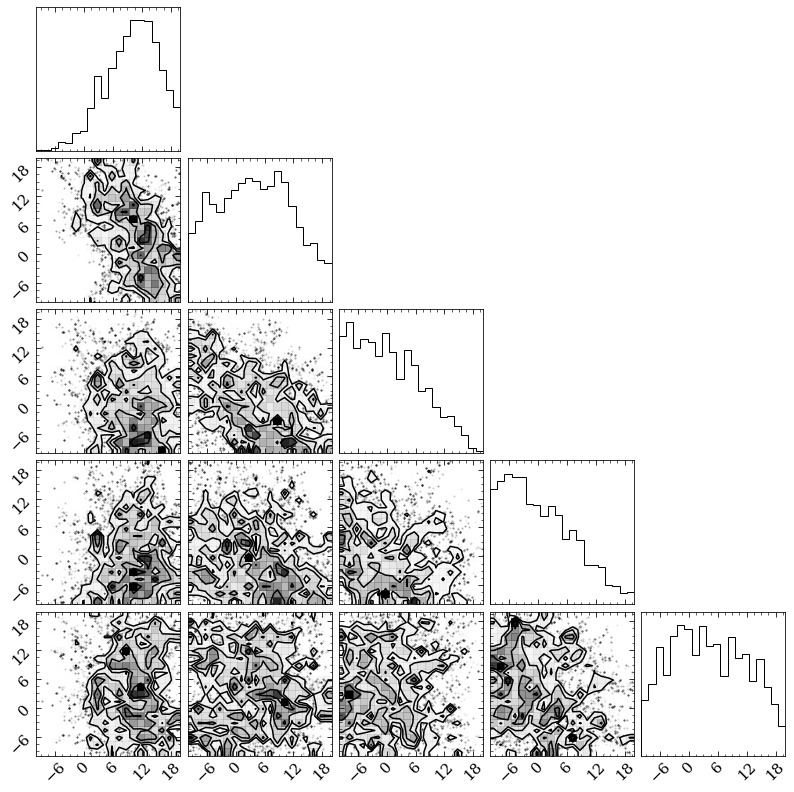

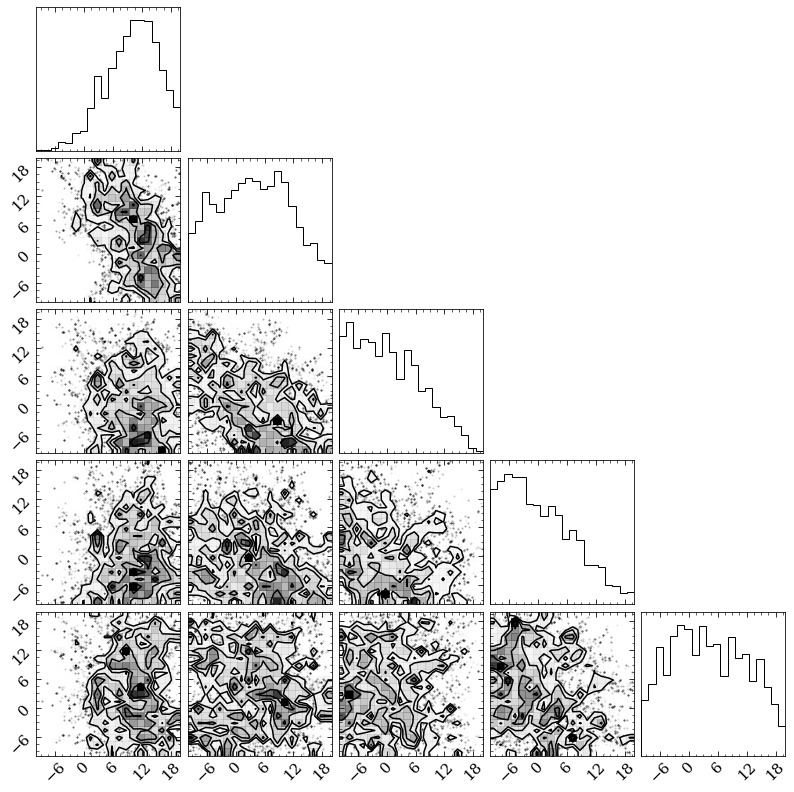

In [50]:
corner.corner(chain[-100:, :, :sightlines[0].ndim].reshape((-1, sightlines[0].ndim)))

In [51]:
# samples = sl.sampler.chain[:, int(0.8 * sampler.chain.shape[1]), :]

def make_plots(samples, sl, logprob = None, chain = None):
    v = np.nanmedian(samples[:, :sl.ndim], axis = 0)
    davdd = np.nanmedian(samples[:, sl.ndim:2*sl.ndim], axis = 0)
    av_offset = np.nanmedian(samples[:, 2*sl.ndim:], axis = 0)
    davdd_all = np.ones((sl.nsig, sl.ndim)) * davdd + av_offset.reshape((sl.nsig, sl.ndim))

    if logprob is not None: 

        best_step, best_walker = np.unravel_index(np.argmax(logprob), logprob.shape)
        davdd = chain[best_step, best_walker, sl.ndim:2*sl.ndim]
        print(davdd.shape)
        davdd_all = davdd * np.ones((sl.nsig, sl.ndim)) + av_offset.reshape((sl.nsig, sl.ndim))


    model_signals = sl.model_signals(v, davdd_all)
    print( model_signals.shape)

    fig, ax = plt.subplots(figsize = (10, 20))

    for i in range(len(model_signals)):
        j = sl.bin_inds[i] - 1

        ax.plot(wavs[window], model_signals[j, :] + 0.1 * j, color = 'C{}'.format(i))        
        ax.plot(wavs[window], sl.signals[j, :]+ 0.1 * j, color = 'C{}'.format(i))
        print(sl.stars[j]['DIST'])


    # fig, ax = plt.subplots()
    # ax.hist(v.flatten(), bins = 50, histtype = 'step', color = 'k')
    # ax.set_xlabel('Velocity')
    # ax.set_ylabel('Frequency')
    # fig, ax = plt.subplots()
    # ax.hist(davdd.flatten(), bins = 50, histtype = 'step', color = 'k')
    # ax.set_xlabel('dAV/dD')
    # ax.set_ylabel('Frequency')
    # fig, ax = plt.subplots()
    # ax.hist(av_offset.flatten(), bins = 50, histtype = 'step', color = 'k')
    # ax.set_xlabel('AV Offset')
    # ax.set_ylabel('Frequency')
    # plt.show()  

In [52]:
# for i in range(len(sightlines)):
#     sl_i = sightlines[i]
#     chain = chains[i]
#     samples = chain[:, int(0.8 * chain.shape[1]), :]
#     # samples = sl_i.sampler.chain[:, int(0.8 * sampler.chain.shape[1]), :]

#     make_plots(samples, sl_i, logprob = probabilities[i], chain = chains[i])
#     plt.show()

# samples_noAVpriors = chain[:, int(0.8 * chain.shape[1]), :]
# make_plots(samples_noAVpriors, sightlines[0], logprob = log_prob_vals, chain = chain)

In [53]:
def make_plots_sample(samples, sl, logprob = None, chain = None):
    v = np.nanmedian(samples[:, :sl.ndim], axis = 0)
    davdd = np.nanmedian(samples[:, sl.ndim:2*sl.ndim], axis = 0)
    av_offset = np.nanmedian(samples[:, 2*sl.ndim:], axis = 0)
    davdd_all = np.ones((sl.nsig, sl.ndim)) * davdd + av_offset.reshape((sl.nsig, sl.ndim))

    if False: 
        best_step, best_walker = np.unravel_index(np.argmax(logprob), logprob.shape)
        davdd = chain[best_step, best_walker, sl.ndim:2*sl.ndim]
        print(davdd.shape)
        davdd_all = davdd * np.ones((sl.nsig, sl.ndim)) + av_offset.reshape((sl.nsig, sl.ndim))

    def sample_signal():
        idx = (np.random.choice(samples.shape[0]))
        v = samples[idx, :sl.ndim]
        av = samples[idx, sl.ndim:2*sl.ndim]
        av_scatter = samples[idx, 2*sl.ndim:]
        davdd_all = av * np.ones((sl.nsig, sl.ndim)) + av_scatter.reshape((sl.nsig, sl.ndim))
        model_signals = sl.model_signals(v, davdd_all)
        return model_signals

    model_signals = sl.model_signals(v, davdd_all)
    print( model_signals.shape)

    fig, ax = plt.subplots(figsize = (10, 20))


    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # bindex = sl.bin_inds[ii]
        # ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        # ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * i,
        #                  sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * i, color = 'C{}'.format(bindex), alpha = 0.1)


        ax.plot(wavs[window], model_signals[ii, :] + 0.1 * i, color = 'C{}'.format(i))        
        ax.plot(wavs[window], sl.signals[ii, :]+ 0.1 * i, color = 'C{}'.format(i))
        for k in range(50):
            ax.plot(wavs[window], sample_signal()[ii, :] + 0.1 * i, color = 'C{}'.format(i), alpha = 0.05)
        ax.set_xlabel('Wavelength ($\AA$)')
        ax.set_ylabel('Flux + Offset')

(5, 95)


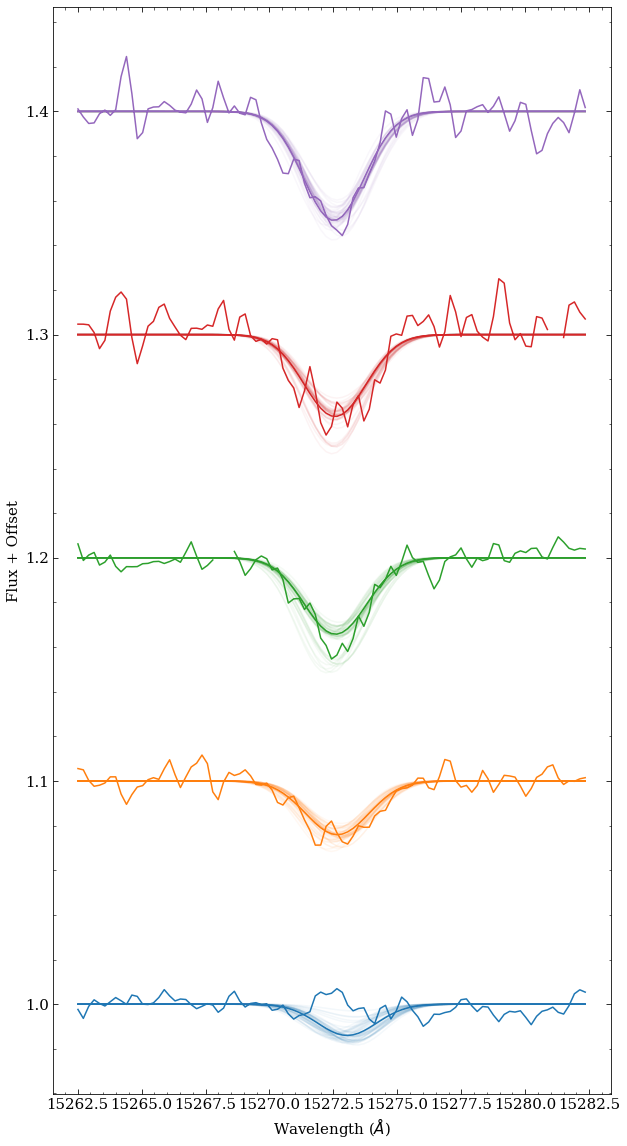

(5, 95)


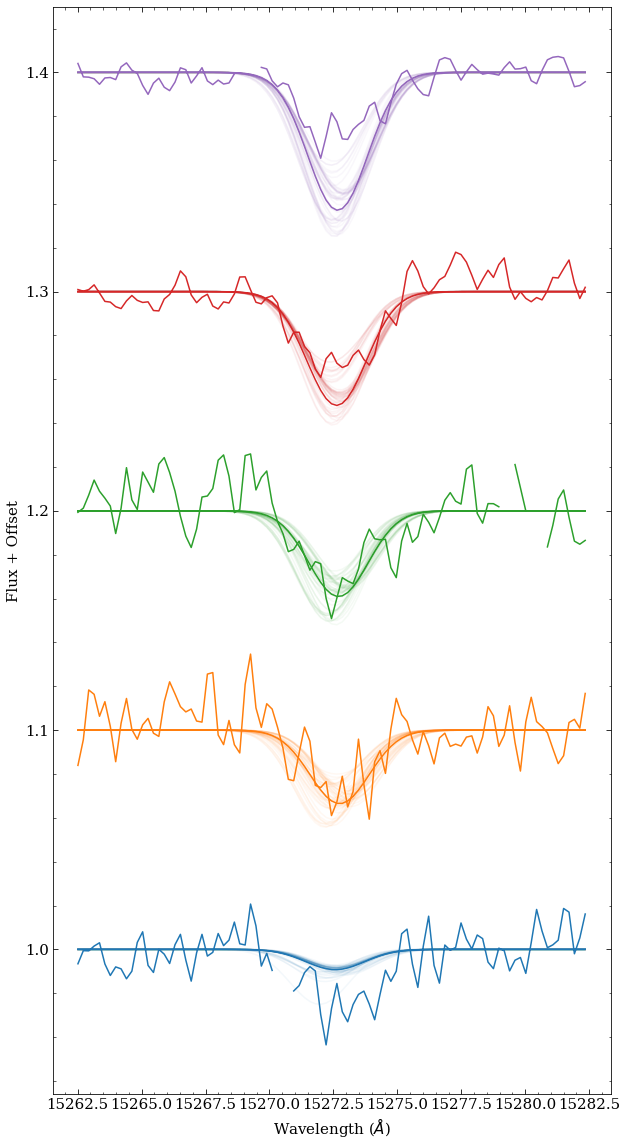

(5, 95)


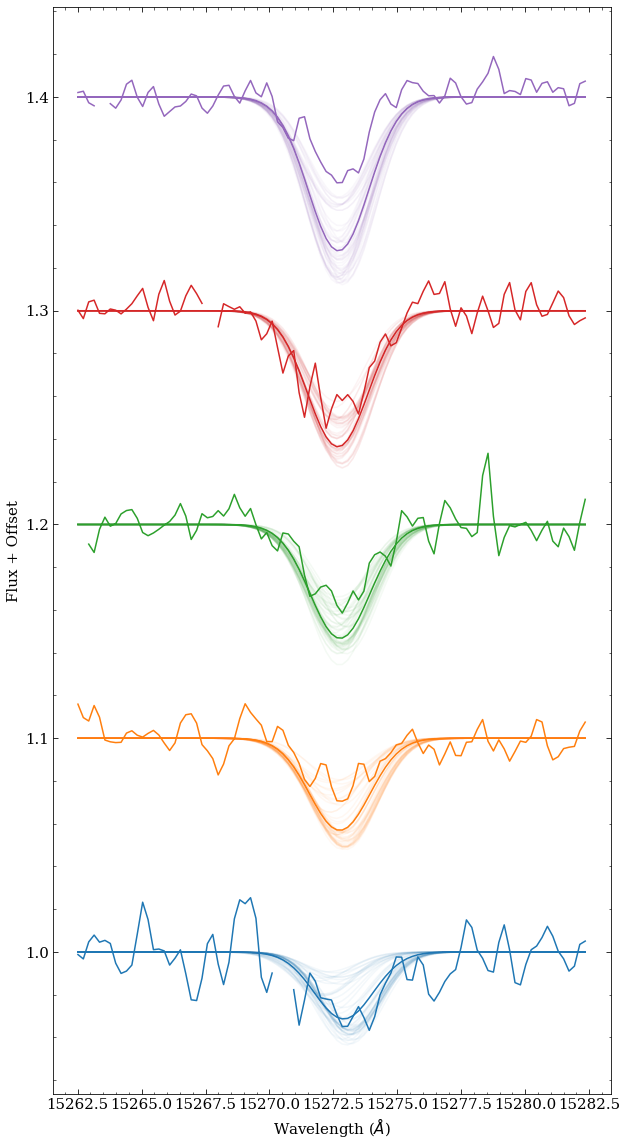

In [54]:
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    chain = chains[i]
    samples = chain[:, int(0.8 * chain.shape[1]), :]
    # samples = sl_i.sampler.chain[:, int(0.8 * sampler.chain.shape[1]), :]

    make_plots_sample(samples, sl_i, logprob = probabilities[i], chain = chains[i])
    plt.show()

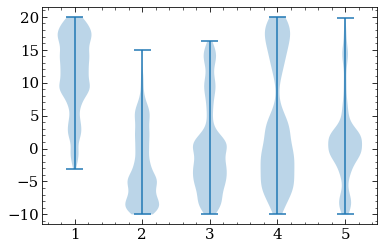

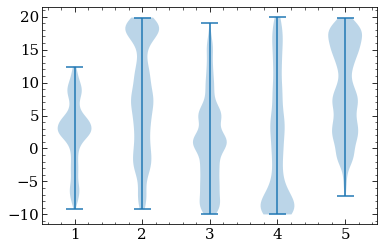

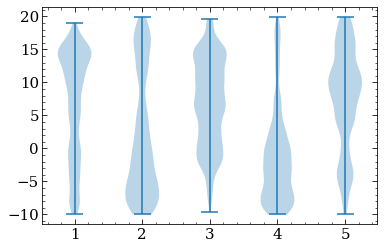

In [55]:
def velo_plots(sl, chain):
    samples = chain[:, int(0.8 * chain.shape[1]), :]
    fig, ax = plt.subplots()
    ax.violinplot(samples[:, :sl.ndim])
    
for i in range(len(sightlines)):
    velo_plots(sightlines[i], chains[i])
    plt.show()